# Skin cancer detection

Dataset taken from Kaggle at [Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [3]:
train_images_fs

array([[[[141., 110., 116.],
         [145., 116., 121.],
         [147., 118., 122.],
         ...,
         [122.,  94.,  91.],
         [121.,  93.,  90.],
         [120.,  92.,  89.]],

        [[143., 111., 116.],
         [145., 114., 120.],
         [146., 117., 122.],
         ...,
         [120.,  92.,  89.],
         [122.,  94.,  91.],
         [122.,  94.,  91.]],

        [[141., 110., 116.],
         [143., 110., 117.],
         [146., 113., 120.],
         ...,
         [121.,  93.,  90.],
         [120.,  92.,  89.],
         [124.,  96.,  93.]],

        ...,

        [[157., 130., 135.],
         [162., 140., 143.],
         [159., 139., 140.],
         ...,
         [ 80.,  52.,  51.],
         [ 77.,  49.,  46.],
         [ 78.,  50.,  49.]],

        [[156., 131., 124.],
         [157., 132., 128.],
         [166., 140., 139.],
         ...,
         [ 76.,  51.,  46.],
         [ 74.,  49.,  44.],
         [ 71.,  48.,  42.]],

        [[159., 134., 129.],
       

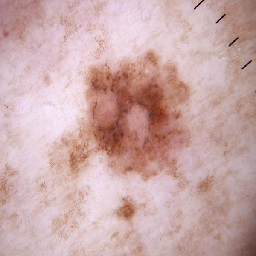

In [4]:
# Preview an image
array_to_img(train_images_fs[0])

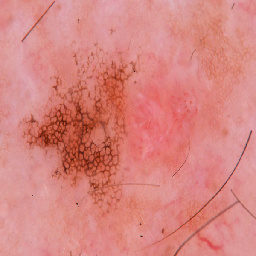

In [5]:
# Preview an image
array_to_img(test_images_fs[0])

In [6]:
train_labels.shape

(2239, 9)

In [7]:
test_labels.shape

(118, 9)

In [8]:
test_images_fs.shape

(118, 256, 256, 3)

In [9]:
train_images_fs.shape

(2239, 256, 256, 3)

In [10]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [11]:
type(train_labels)

numpy.ndarray

In [12]:
type(train_images_fs)

numpy.ndarray

In [13]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [14]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#dataframe.hist()

In [16]:
sums=dataframe.sum(axis=0)

In [17]:
sums=pd.DataFrame(sums)

In [18]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [19]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [20]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


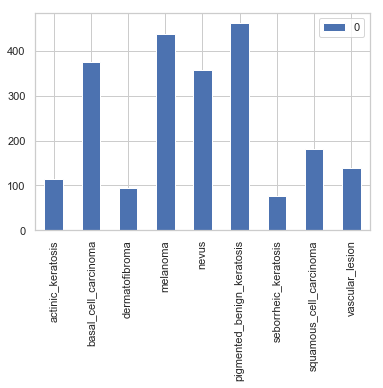

In [21]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

In [22]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

Defining a function to visualize the results.

In [23]:
"""def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()"""

"def visualize_training_results(results):\n    history = results.history\n    plt.figure()\n    plt.plot(history['val_loss'])\n    plt.plot(history['loss'])\n    plt.legend(['val_loss', 'loss'])\n    plt.title('Loss')\n    plt.xlabel('Epochs')\n    plt.ylabel('Loss')\n    plt.show()\n    \n    plt.figure()\n    plt.plot(history['val_accuracy'])\n    plt.plot(history['accuracy'])\n    plt.legend(['val_accuracy', 'accuracy'])\n    plt.title('Accuracy')\n    plt.xlabel('Epochs')\n    plt.ylabel('Accuracy')\n    plt.show()"

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.

Let us forget about all of this and try with the 2D actual convolutional neural network for images. The perfmormance there might be different.

We can also do something else which is group together the types of skin abnormalities that are cancerous and the ones that are not, reducing the classes to 2 and making this a binary classification problem.
I will do that later on. For now let's see what happens with a convolutional neural network, which is what I should be doing anyway.

Here also definitely preview one image per class and explain a bit about each class.

## Preprocessing

In [24]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [25]:
# Explore your dataset again
m_train = train_img32.shape[0]
num_px = train_img32.shape[1]
m_test = test_img32.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img32.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img32.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [26]:
train_lab.shape[0]

2239

In [27]:
#train_img = train_img.reshape(train_img.shape[0], -1)
#test_img = test_img.reshape(test_img.shape[0], -1)
#val_img = val_images.reshape(val_images.shape[0], -1)

#print(val_img.shape)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225,
and we are also going to reshape the data in a format that can be fed into the model.
We are going to put these two preprocessing steps together with a pipeline.

#### Here I am going to create my first pipeline 
to use to scale and reshape the data once I have loaded it
Or possibly even a function to load it.

to standardize the pixel values:

In [28]:
def scale_pixels(train_img, test_img, train_lab, test_lab):
    train_img /= 255.
    test_img /= 255.
    return train_img, test_img

In [29]:
# Instantiate transformer
pix_scaler = FunctionTransformer(scale_pixels)

In [30]:
"""pix_scaler.fit_transform(train_img32, test_img32, train_lab, test_lab)"""

'pix_scaler.fit_transform(train_img32, test_img32, train_lab, test_lab)'

In [31]:
#pix_scaler.transform(train_img, test_img)

In [32]:
#from sklearn.preprocessing import StandardScaler
#StandardScaler().fit_transform(train_img)

In [33]:
test_img32.shape

(118, 32, 32, 3)

In [34]:
train_img32.shape

(2239, 32, 32, 3)

In [35]:
# Instantiate StandardScaler
#scaler = MinMaxScaler()
# Transform the training and test sets
#scaled_data_train = scaler.fit_transform(train_img)
#scaled_data_test = scaler.transform(test_img)

# Convert into a DataFrame
#scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
#scaled_df_train.head()

In [36]:
#scale_pixels(train_img, test_img)

In [37]:
#train_img

To change the shape of the labels:

In [38]:
def reshape (train_lab, test_lab): #(train_img, test_img, train_lab, test_lab):
    m=train_lab.shape[0]
    n=test_lab.shape[0]
    train_lab = np.reshape(train_lab[:,0], (m,1))
    test_lab = np.reshape(test_lab[:,0], (n,1))
    return train_lab, test_lab

In [39]:
# Instantiate transformer
shaper = FunctionTransformer(reshape)

In [40]:
print(train_lab.shape)
print(test_lab.shape)

(2239, 9)
(118, 9)


In [41]:
#train_y, test_y=reshape(train_lab, test_lab)

In [42]:
"""shaper.fit_transform(train_lab, test_lab)#(train_img, test_img, train_lab, test_lab)"""

'shaper.fit_transform(train_lab, test_lab)#(train_img, test_img, train_lab, test_lab)'

In [43]:
print(train_lab.shape)
print(test_lab.shape)

(2239, 9)
(118, 9)


In [44]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [45]:
print(train_y.shape)
print(test_y.shape)

(2239, 1)
(118, 1)


In [46]:
"""ct=make_column_transformer(
    (pix_scaler, ['img_scaled']),
    (shaper, ['labels_reshaped']))"""

"ct=make_column_transformer(\n    (pix_scaler, ['img_scaled']),\n    (shaper, ['labels_reshaped']))"

In [47]:
"""ct.fit_transform(train_img, test_img, train_lab, test_lab)"""

'ct.fit_transform(train_img, test_img, train_lab, test_lab)'

In [48]:
# Build a pipeline with StandardScaler and KNeighborsClassifier
"""scale_pipeline = Pipeline([('pixel scaler', pix_scaler(train_img, test_img)),
        ('changing shape', shaper(train_lab, test_lab))])"""

"scale_pipeline = Pipeline([('pixel scaler', pix_scaler(train_img, test_img)),\n        ('changing shape', shaper(train_lab, test_lab))])"

In [49]:
"""scale_pipeline.fit_transform(train_img, test_img, train_lab, test_lab)"""

'scale_pipeline.fit_transform(train_img, test_img, train_lab, test_lab)'

In [50]:
"""# Fit the training data to pipeline
scaled_pipeline_1.fit(X_train, y_train)

# Print the accuracy on test set
scaled_pipeline_1.score(X_test, y_test)"""

'# Fit the training data to pipeline\nscaled_pipeline_1.fit(X_train, y_train)\n\n# Print the accuracy on test set\nscaled_pipeline_1.score(X_test, y_test)'

Building two functions that will help us visualize and compare the different models:

In [51]:
def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty dataframe where we will store the results:

In [52]:
# create an Empty DataFrame object
df = pd.DataFrame()

In [53]:
def model_results(results, model_name, df):
    visualize_training_results(results)
    df1 = pd.DataFrame({'Name': [model_name],
                        'accuracy train': [round(results.history['acc'][-1],5)] ,
                        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
                        'loss train': [round(results.history['loss'][-1],5)],
                        'loss validation': [round(results.history['val_loss'][-1],5)]})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

And let us create another function to generate models.
With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
We will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy.

In [54]:
def create_model(input_shape, activation='relu', loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , neur1=10, neur2=32, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

And one more function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.

In [55]:
def fit_model(model, train, y, epo=10, batch=10, val_split=0.3):
    results = model.fit(train, y, epochs=epo, batch_size=batch, validation_split=val_split)
    return results

In [56]:
#visualize_training_results(history)

**Let me try them**

In [57]:
mod1=create_model((32,32,3), neur1=15, neur2=20 )

In [58]:
results=fit_model(mod1, train_img32, train_y)

Epoch 1/10
157/157 [==============================] - 3s 12ms/step - loss: 0.9998 - acc: 0.9126 - val_loss: 0.2412 - val_acc: 0.9405
Epoch 2/10
157/157 [==============================] - 2s 11ms/step - loss: 0.2640 - acc: 0.9464 - val_loss: 0.2242 - val_acc: 0.9405
Epoch 3/10
157/157 [==============================] - 2s 11ms/step - loss: 0.2245 - acc: 0.9483 - val_loss: 0.2067 - val_acc: 0.9405
Epoch 4/10
157/157 [==============================] - 2s 11ms/step - loss: 0.2337 - acc: 0.9521 - val_loss: 0.3530 - val_acc: 0.9405
Epoch 5/10
157/157 [==============================] - 2s 11ms/step - loss: 0.2263 - acc: 0.9521 - val_loss: 0.7059 - val_acc: 0.9405
Epoch 6/10
157/157 [==============================] - 2s 11ms/step - loss: 0.2099 - acc: 0.9502 - val_loss: 0.2969 - val_acc: 0.9405
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.2173 - acc: 0.9521 - val_loss: 0.3405 - val_acc: 0.9390
Epoch 8/10
157/157 [==============================] - 2s 11ms/step - 

### Trying to pick a Naive model

Trying with a simple model:

In [59]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

And doing only 10 epochs:

In [60]:
history1 = model.fit(train_img32,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 2s 7ms/step - loss: 6.6579 - acc: 0.8890 - val_loss: 0.3630 - val_acc: 0.9196
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3964 - acc: 0.9279 - val_loss: 0.2906 - val_acc: 0.9390
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3628 - acc: 0.9355 - val_loss: 0.2531 - val_acc: 0.9345
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3017 - acc: 0.9336 - val_loss: 0.6265 - val_acc: 0.9390
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3082 - acc: 0.9375 - val_loss: 0.4934 - val_acc: 0.9405
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2886 - acc: 0.9464 - val_loss: 0.4676 - val_acc: 0.9405
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3294 - acc: 0.9432 - val_loss: 0.5086 - val_acc: 0.9315
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 0.

Let us visualize the results of this first model:
The bottom two graphs will make sense only later on since we are building a learning curve, to compare the different models' performance.

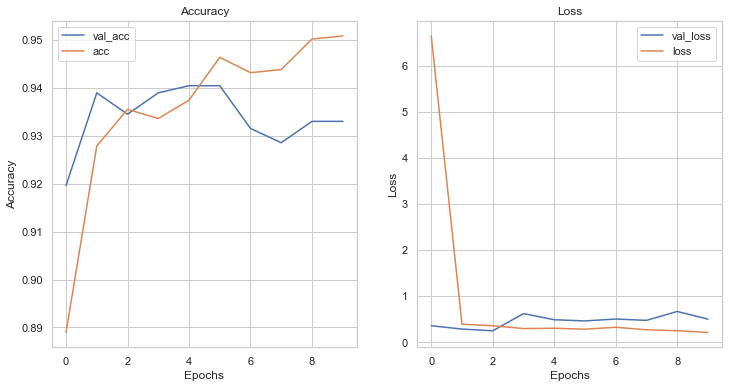

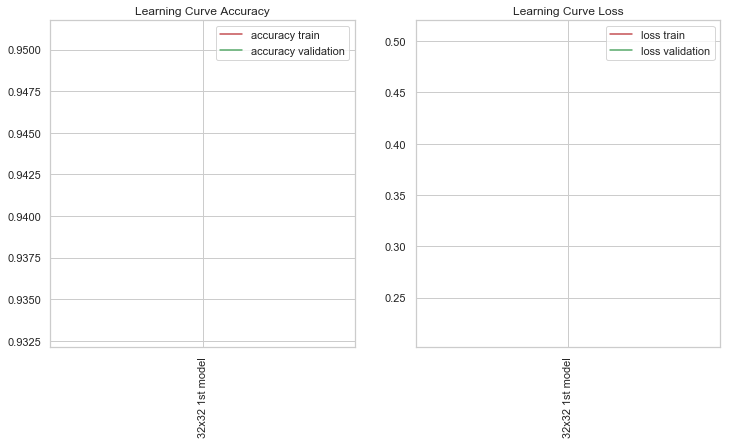

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.95086,0.93304,0.21665,0.50586


In [61]:
df=model_results(history1, '32x32 1st model', df)
df

Another attempt: all the previous parameters but making the last dense layer smaller.

In [62]:
model2 = models.Sequential()
model2.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [63]:
history3 = model2.fit(train_img32,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 19ms/step - loss: 7.7976 - acc: 0.7582 - val_loss: 2.1213 - val_acc: 0.9442
Epoch 2/10
36/36 [==============================] - 1s 17ms/step - loss: 2.1470 - acc: 0.9503 - val_loss: 2.0857 - val_acc: 0.9442
Epoch 3/10
36/36 [==============================] - 1s 16ms/step - loss: 2.0567 - acc: 0.9503 - val_loss: 2.0275 - val_acc: 0.9442
Epoch 4/10
36/36 [==============================] - 1s 16ms/step - loss: 1.9983 - acc: 0.9503 - val_loss: 1.9698 - val_acc: 0.9442
Epoch 5/10
36/36 [==============================] - 1s 16ms/step - loss: 1.9406 - acc: 0.9503 - val_loss: 1.9127 - val_acc: 0.9442
Epoch 6/10
36/36 [==============================] - 1s 15ms/step - loss: 1.8832 - acc: 0.9503 - val_loss: 1.8562 - val_acc: 0.9442
Epoch 7/10
36/36 [==============================] - 1s 15ms/step - loss: 1.8268 - acc: 0.9503 - val_loss: 1.8006 - val_acc: 0.9442
Epoch 8/10
36/36 [==============================] - 1s 15ms/step - loss: 1.7710 - a

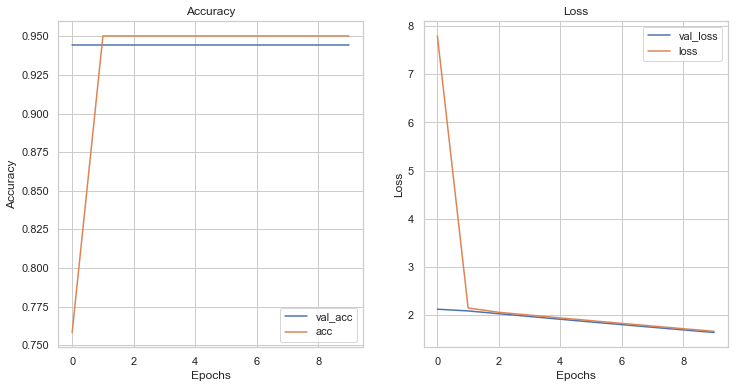

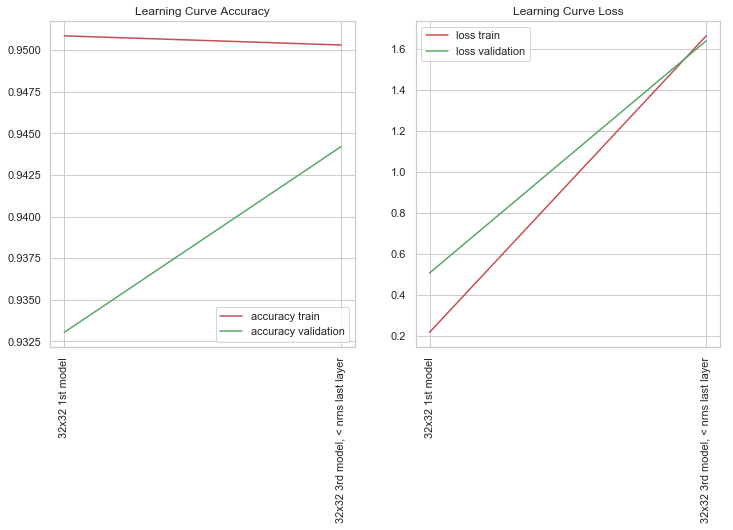

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.95086,0.93304,0.21665,0.50586
0,"32x32 3rd model, < nrns last layer",0.95031,0.94420,1.66183,1.63793


In [64]:
df=model_results(history3, '32x32 3rd model, < nrns last layer', df)
df

#### Even less Neurons:

In [65]:
model3 = models.Sequential()
model3.add(layers.Conv2D(5, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [66]:
history4 = model3.fit(train_img32,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 18ms/step - loss: 3.8018 - acc: 0.4478 - val_loss: 2.1218 - val_acc: 0.9129
Epoch 2/10
36/36 [==============================] - 1s 15ms/step - loss: 2.0514 - acc: 0.7850 - val_loss: 1.9939 - val_acc: 0.8594
Epoch 3/10
36/36 [==============================] - 1s 15ms/step - loss: 1.4980 - acc: 0.7275 - val_loss: 1.1520 - val_acc: 0.9442
Epoch 4/10
36/36 [==============================] - 1s 15ms/step - loss: 0.9230 - acc: 0.9503 - val_loss: 0.8962 - val_acc: 0.9420
Epoch 5/10
36/36 [==============================] - 1s 15ms/step - loss: 0.6850 - acc: 0.9503 - val_loss: 0.8061 - val_acc: 0.9442
Epoch 6/10
36/36 [==============================] - 1s 15ms/step - loss: 0.5622 - acc: 0.9481 - val_loss: 0.8048 - val_acc: 0.9420
Epoch 7/10
36/36 [==============================] - 1s 14ms/step - loss: 0.5115 - acc: 0.9486 - val_loss: 0.8516 - val_acc: 0.9442
Epoch 8/10
36/36 [==============================] - 1s 15ms/step - loss: 0.4325 - a

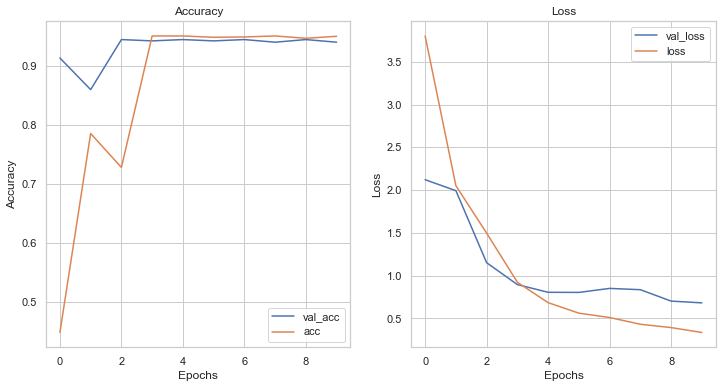

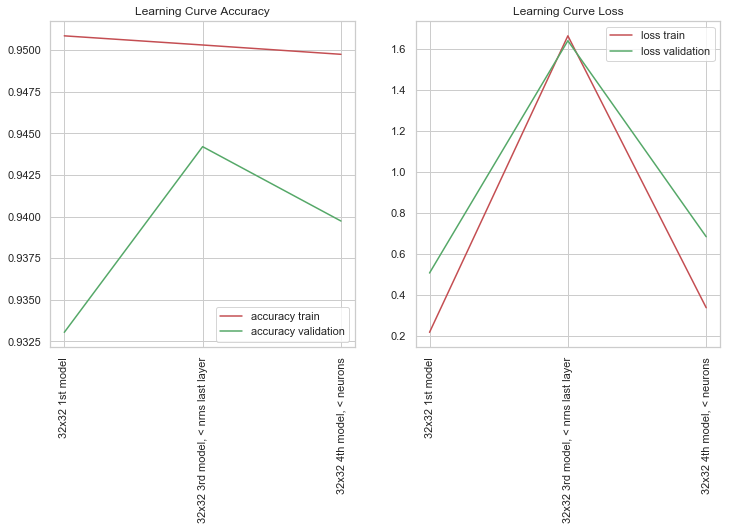

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.95086,0.93304,0.21665,0.50586
0,"32x32 3rd model, < nrns last layer",0.95031,0.94420,1.66183,1.63793
0,"32x32 4th model, < neurons",0.94975,0.93973,0.33659,0.68265


In [67]:
df=model_results(history4, '32x32 4th model, < neurons', df)
df

#### Less resolution images.

In [68]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
#test_gen= ImageDataGenerator().flow_from_directory(
#        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
#test_img, test_lab = next(test_gen)

Found 2239 images belonging to 9 classes.


In [69]:
train_img8.shape

(2239, 8, 8, 3)

In [70]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [71]:
model5 = models.Sequential()
model5.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
model5.add(layers.Dense(9, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [72]:
history5 = model5.fit(train_img8,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 37.9580 - acc: 0.6082 - val_loss: 2.0750 - val_acc: 0.9092
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.8545 - acc: 0.9489 - val_loss: 1.7449 - val_acc: 0.9241
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 1.5925 - acc: 0.9534 - val_loss: 1.4992 - val_acc: 0.9271
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 1.3680 - acc: 0.9553 - val_loss: 1.2925 - val_acc: 0.9286
Epoch 5/10
157/157 [==============================] - 0s 2ms/step - loss: 1.1643 - acc: 0.9566 - val_loss: 1.1058 - val_acc: 0.9301
Epoch 6/10
157/157 [==============================] - 0s 2ms/step - loss: 0.9826 - acc: 0.9566 - val_loss: 0.9423 - val_acc: 0.9286
Epoch 7/10
157/157 [==============================] - 0s 2ms/step - loss: 0.8238 - acc: 0.9566 - val_loss: 0.8006 - val_acc: 0.9301
Epoch 8/10
157/157 [==============================] - 0s 2ms/step - loss: 0

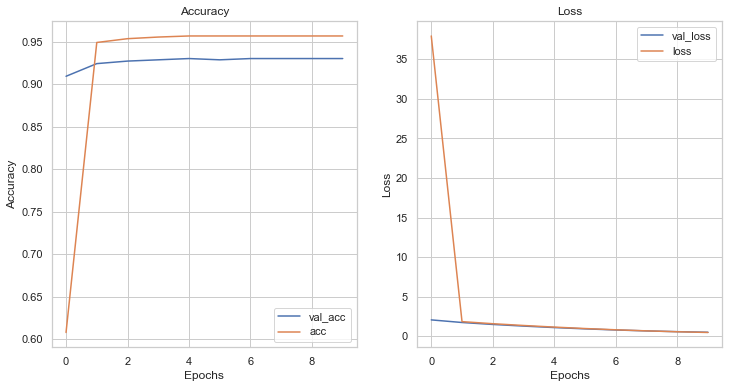

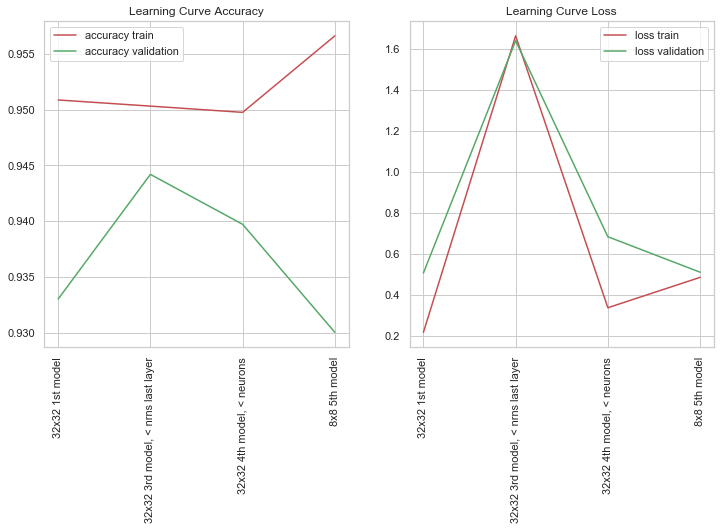

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.95086,0.93304,0.21665,0.50586
0,"32x32 3rd model, < nrns last layer",0.95031,0.94420,1.66183,1.63793
0,"32x32 4th model, < neurons",0.94975,0.93973,0.33659,0.68265
0,8x8 5th model,0.95660,0.93006,0.48462,0.50979


In [73]:
df=model_results(history5, '8x8 5th model', df)
df

[Let me try to decrease the batch size already from the import, see if is changes anything.]

In [74]:
"""# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=5)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=20)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)"""

"# Directory path\ntrain_data_dir = 'dataskin/Train'\ntest_data_dir = 'dataskin/Test'\n#val_data_dir = 'dataset/validation_set'\n\n# Get all the data in the directory data/validation (118 images), and reshape them\ntest_gen= ImageDataGenerator().flow_from_directory(\n        test_data_dir, target_size=(8, 8), batch_size=5)\n\n# Get all the data in the directory data/train (2239 images), and reshape them\ntrain_gen = ImageDataGenerator().flow_from_directory(\n        train_data_dir, target_size=(8, 8), batch_size=20)\n\n# Create the datasets\ntrain_img, train_lab = next(train_gen)\ntest_img, test_lab = next(test_gen)"

In [75]:
#train_y = np.reshape(train_lab[:,0], (20,1))
#test_y = np.reshape(test_lab[:,0], (5,1))

In [76]:
#history6 = model5.fit(train_img,
#                    train_y,
#                    epochs=10,
#                    batch_size=10, validation_split=0.3)

In [77]:
#df=model_results(history6, '8x8 5th model < batch on import', df)
#df

The good news is that even if the results change a lot in the first part where I do regualr NN, every time I run the code, they don't change so radically with the CNN.
I will keep track a bit but overall it seems like I can stop worrying about reproducibe results, if I use CNN right away.

## Starting to improve our model:

Taking from the german signs notebook

Nope. It's in AWS Sagemaker. But I can look back at it and use either a simple pipeline for loading and changing the size of the images, or for images augmentation to balance the classes of the different skin anomalies.
<br>A simple pipeline can even be "load, normalize, augment".

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - change activation function and optimization
    
After we have done all this we will select the best performing model and we will also group up into 2 classes, cancerous and benign growth too.
<br>Maybe I should do that now actually.
<br>No I will do it after this first selection so I can say I have a good model to predict which of the 9 classes with this much accuracy.
<br>And then introduce the concept of two classes and decreasing recall.
<br>After that anyhow, do another round of tuning for the model, this time using:
 - drop out layers
 - regularization
 - normalization
 - data augmentation
 - balancing classes with data augmentation
 

### Improving the model with 9 classes:

Restart with an empty dataframe because while before we were looking for the lowest performance model now we are looking to improve it.

In [78]:
df = pd.DataFrame()

Let us start by visualizing again the results from what we picked to be our naive model:

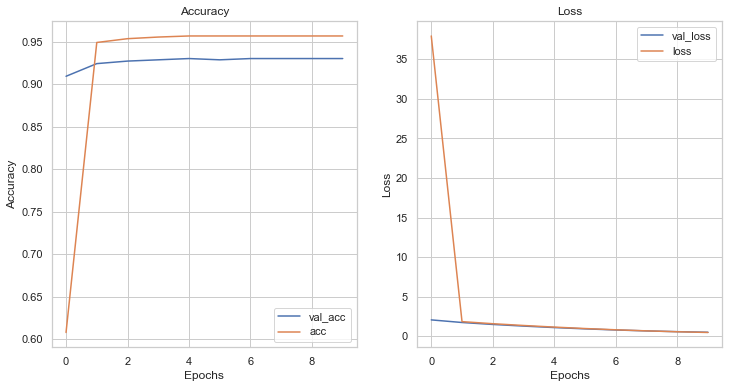

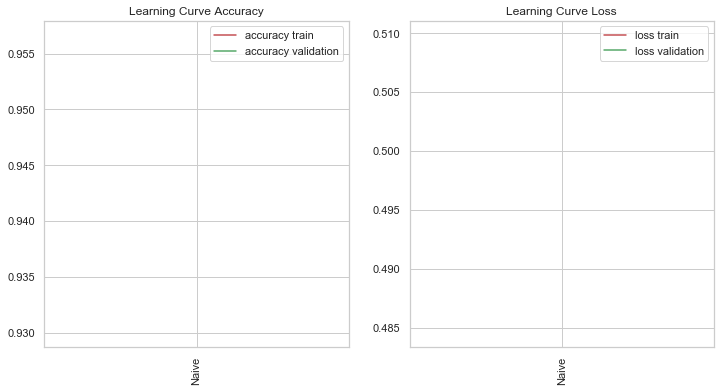

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.9566,0.93006,0.48462,0.50979


In [79]:
df=model_results(history5, 'Naive', df)
df

#### Normalize the data:

To standardize the pixel values:

In [80]:
train_img8 /= 255.

In [81]:
train_img8

array([[[[0.40392157, 0.38431373, 0.4117647 ],
         [0.5411765 , 0.5176471 , 0.57254905],
         [0.6       , 0.5882353 , 0.654902  ],
         ...,
         [0.5058824 , 0.4509804 , 0.50980395],
         [0.5686275 , 0.5764706 , 0.63529414],
         [0.48235294, 0.4745098 , 0.5176471 ]],

        [[0.5176471 , 0.50980395, 0.56078434],
         [0.53333336, 0.49019608, 0.5137255 ],
         [0.6117647 , 0.5882353 , 0.6901961 ],
         ...,
         [0.62352943, 0.6117647 , 0.6862745 ],
         [0.59607846, 0.6       , 0.6784314 ],
         [0.5176471 , 0.52156866, 0.5411765 ]],

        [[0.5294118 , 0.5176471 , 0.5529412 ],
         [0.5686275 , 0.52156866, 0.5372549 ],
         [0.6039216 , 0.5764706 , 0.6392157 ],
         ...,
         [0.6117647 , 0.58431375, 0.64705884],
         [0.5803922 , 0.57254905, 0.6156863 ],
         [0.54901963, 0.5764706 , 0.6156863 ]],

        ...,

        [[0.5254902 , 0.5176471 , 0.5372549 ],
         [0.5803922 , 0.5647059 , 0.61960787]

In [82]:
history52 = model5.fit(train_img8,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 0s 2ms/step - loss: 0.4121 - acc: 0.9566 - val_loss: 0.4478 - val_acc: 0.9315
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 0.3558 - acc: 0.9566 - val_loss: 0.4031 - val_acc: 0.9315
Epoch 3/10
157/157 [==============================] - 0s 2ms/step - loss: 0.3131 - acc: 0.9566 - val_loss: 0.3701 - val_acc: 0.9315
Epoch 4/10
157/157 [==============================] - 0s 2ms/step - loss: 0.2816 - acc: 0.9566 - val_loss: 0.3463 - val_acc: 0.9315
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 0.2581 - acc: 0.9566 - val_loss: 0.3290 - val_acc: 0.9315
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 0.2411 - acc: 0.9566 - val_loss: 0.3166 - val_acc: 0.9315
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 0.2286 - acc: 0.9566 - val_loss: 0.3076 - val_acc: 0.9315
Epoch 8/10
157/157 [==============================] - 0s 2ms/step - loss: 0.

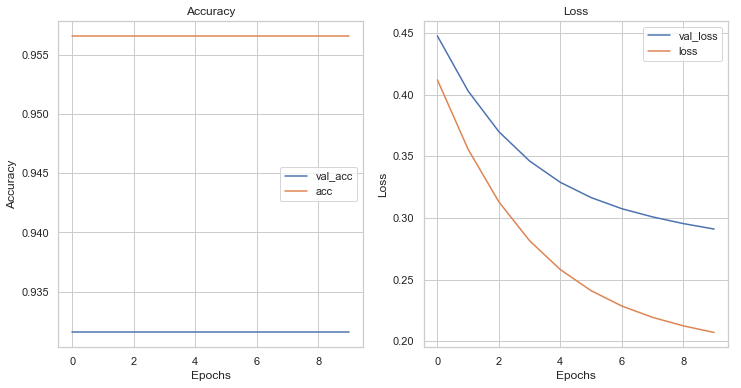

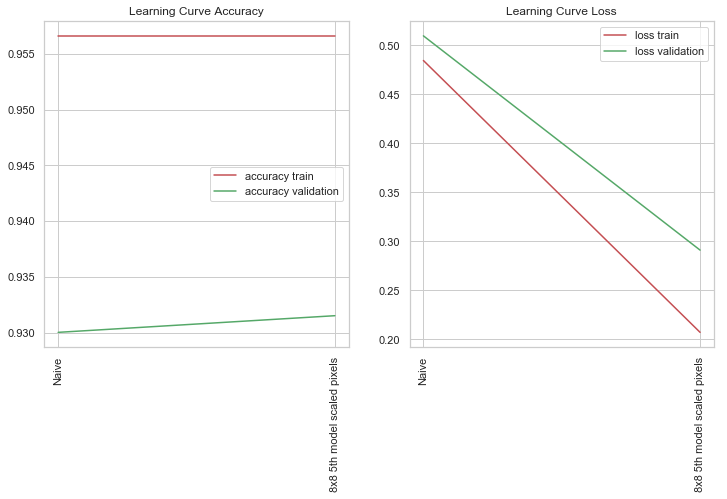

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.9566,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.9566,0.93155,0.20714,0.29107


In [83]:
df=model_results(history52, '8x8 5th model scaled pixels', df)
df

#### Increasing Image resolution:

In [84]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img64, train_lab = next(train_gen)
#test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
#test_img64 /= 255.

Found 2239 images belonging to 9 classes.


In [85]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [86]:
model6 = models.Sequential()
model6.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Flatten())
model6.add(layers.Dense(9, activation='softmax'))

model6.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [87]:
history6b = model6.fit(train_img64,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 2s 13ms/step - loss: 0.2591 - acc: 0.9438 - val_loss: 0.2305 - val_acc: 0.9464
Epoch 2/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2203 - acc: 0.9502 - val_loss: 0.2284 - val_acc: 0.9464
Epoch 3/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2161 - acc: 0.9502 - val_loss: 0.2268 - val_acc: 0.9464
Epoch 4/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2042 - acc: 0.9502 - val_loss: 0.1984 - val_acc: 0.9464
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1977 - acc: 0.9502 - val_loss: 0.2028 - val_acc: 0.9464
Epoch 6/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1868 - acc: 0.9502 - val_loss: 0.2298 - val_acc: 0.9464
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1797 - acc: 0.9502 - val_loss: 0.2122 - val_acc: 0.9464
Epoch 8/10
157/157 [==============================] - 2s 12ms/step - 

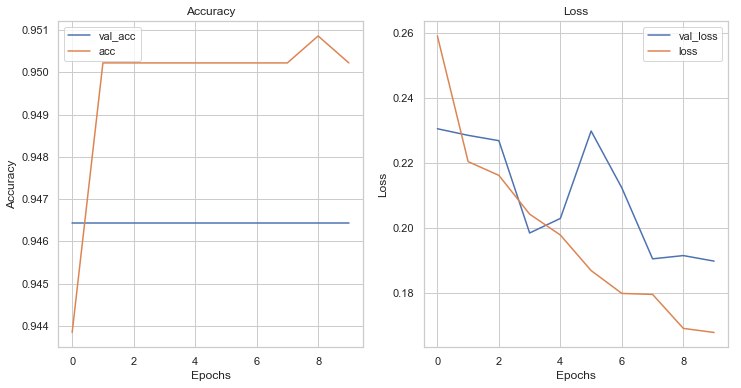

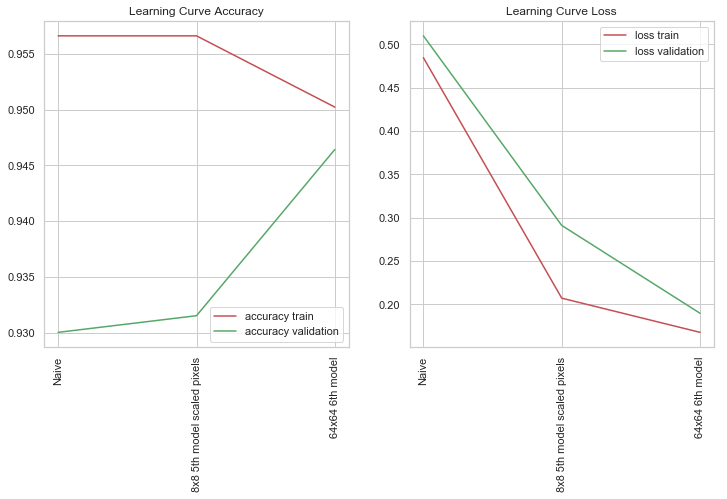

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.95660,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.95660,0.93155,0.20714,0.29107
0,64x64 6th model,0.95022,0.94643,0.16770,0.18968


In [88]:
df=model_results(history6b, '64x64 6th model', df)
df

Let us try increasing the size of the images imported further. Let us go all the way to the actually full size which is 256. These are already loaded at the beginning and are sotred in train_images_fs, test_images_fs.

In [89]:
#normalizing again
train_images_fs /= 255.
test_images_fs /= 255.

In [90]:
model6b = models.Sequential()
model6b.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model6b.add(layers.MaxPooling2D((2, 2)))

model6b.add(layers.Flatten())
model6b.add(layers.Dense(9, activation='softmax'))

model6b.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [91]:
history6c = model6b.fit(train_images_fs,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 21s 132ms/step - loss: 0.4183 - acc: 0.9202 - val_loss: 0.3408 - val_acc: 0.9464
Epoch 2/10
157/157 [==============================] - 19s 122ms/step - loss: 0.3361 - acc: 0.9368 - val_loss: 0.3010 - val_acc: 0.9464
Epoch 3/10
157/157 [==============================] - 21s 136ms/step - loss: 0.3070 - acc: 0.9438 - val_loss: 0.4133 - val_acc: 0.9092
Epoch 4/10
157/157 [==============================] - 24s 154ms/step - loss: 0.2875 - acc: 0.9426 - val_loss: 0.3001 - val_acc: 0.9420
Epoch 5/10
157/157 [==============================] - 21s 133ms/step - loss: 0.2824 - acc: 0.9419 - val_loss: 0.4031 - val_acc: 0.9464
Epoch 6/10
157/157 [==============================] - 28s 181ms/step - loss: 0.2306 - acc: 0.9470 - val_loss: 0.4476 - val_acc: 0.9464
Epoch 7/10
157/157 [==============================] - 22s 139ms/step - loss: 0.2280 - acc: 0.9515 - val_loss: 0.3993 - val_acc: 0.9479
Epoch 8/10
157/157 [==============================] - 1

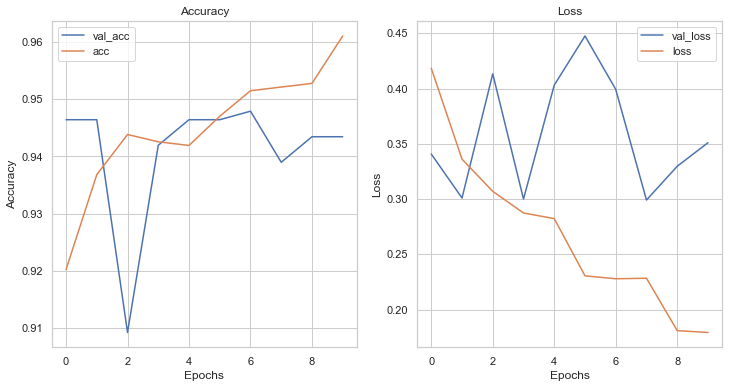

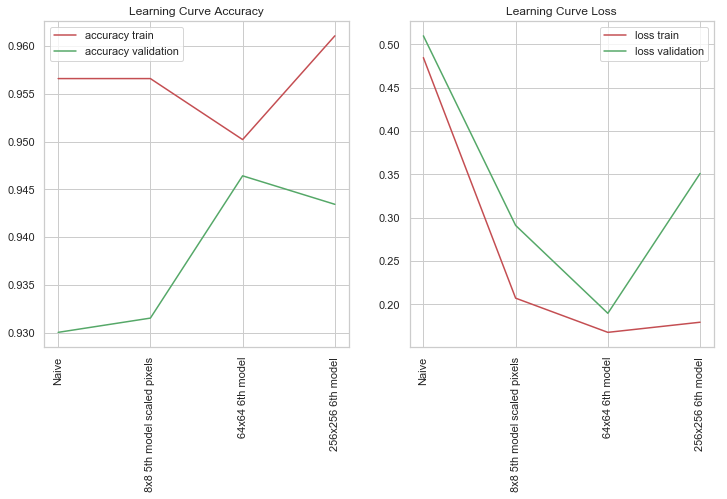

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.95660,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.95660,0.93155,0.20714,0.29107
0,64x64 6th model,0.95022,0.94643,0.16770,0.18968
0,256x256 6th model,0.96107,0.94345,0.17938,0.35100


In [92]:
df=model_results(history6c, '256x256 6th model', df)
df

Let us see what happens with the full size.

#### Increasing number of epochs:

In [93]:
history7 = model6.fit(train_img64,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 2s 13ms/step - loss: 0.1776 - acc: 0.9502 - val_loss: 0.2016 - val_acc: 0.9464
Epoch 2/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1664 - acc: 0.9502 - val_loss: 0.2038 - val_acc: 0.9464
Epoch 3/30
157/157 [==============================] - 4s 23ms/step - loss: 0.1655 - acc: 0.9509 - val_loss: 0.2001 - val_acc: 0.9449
Epoch 4/30
157/157 [==============================] - 4s 24ms/step - loss: 0.1576 - acc: 0.9521 - val_loss: 0.1889 - val_acc: 0.9464
Epoch 5/30
157/157 [==============================] - 3s 21ms/step - loss: 0.1584 - acc: 0.9509 - val_loss: 0.2018 - val_acc: 0.9464
Epoch 6/30
157/157 [==============================] - 2s 13ms/step - loss: 0.1496 - acc: 0.9541 - val_loss: 0.2187 - val_acc: 0.9464
Epoch 7/30
157/157 [==============================] - 5s 29ms/step - loss: 0.1421 - acc: 0.9502 - val_loss: 0.2102 - val_acc: 0.9464
Epoch 8/30
157/157 [==============================] - 4s 24ms/step - 

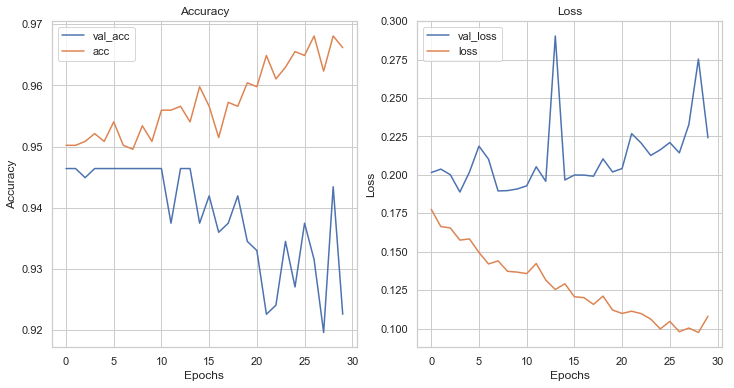

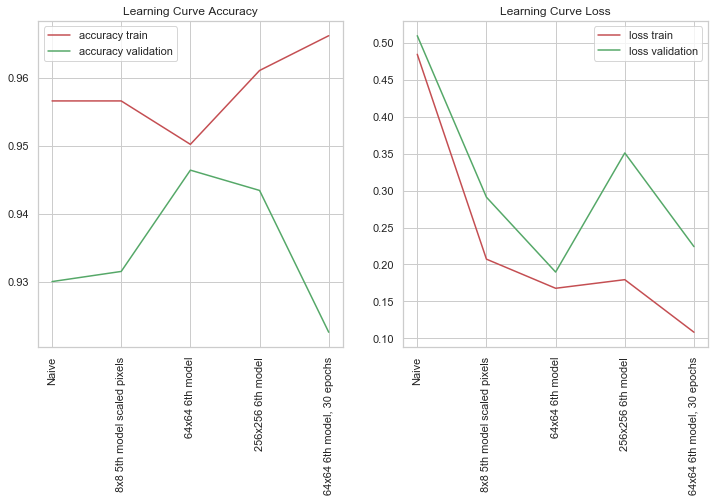

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.95660,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.95660,0.93155,0.20714,0.29107
0,64x64 6th model,0.95022,0.94643,0.16770,0.18968
0,256x256 6th model,0.96107,0.94345,0.17938,0.35100
0,"64x64 6th model, 30 epochs",0.96618,0.92262,0.10818,0.22411


In [94]:
df=model_results(history7, '64x64 6th model, 30 epochs', df)
df

#### Adding more layers:

In [95]:
model7 = models.Sequential()
model7.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model7.add(layers.MaxPooling2D((2, 2)))

model7.add(layers.Conv2D(10, (4, 4), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))

model7.add(layers.Conv2D(32, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))

model7.add(layers.Flatten())
model7.add(layers.Dense(32, activation='relu'))
model7.add(layers.Dense(9, activation='softmax'))

model7.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [96]:
history8 = model7.fit(train_img64,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 8s 49ms/step - loss: 0.2703 - acc: 0.9451 - val_loss: 0.2340 - val_acc: 0.9464
Epoch 2/30
157/157 [==============================] - 6s 35ms/step - loss: 0.2238 - acc: 0.9502 - val_loss: 0.2194 - val_acc: 0.9464
Epoch 3/30
157/157 [==============================] - 5s 30ms/step - loss: 0.2200 - acc: 0.9502 - val_loss: 0.2247 - val_acc: 0.9464
Epoch 4/30
157/157 [==============================] - 5s 34ms/step - loss: 0.2162 - acc: 0.9502 - val_loss: 0.2041 - val_acc: 0.9464
Epoch 5/30
157/157 [==============================] - 7s 47ms/step - loss: 0.2139 - acc: 0.9502 - val_loss: 0.2051 - val_acc: 0.9464
Epoch 6/30
157/157 [==============================] - 5s 29ms/step - loss: 0.2062 - acc: 0.9502 - val_loss: 0.2372 - val_acc: 0.9464
Epoch 7/30
157/157 [==============================] - 4s 29ms/step - loss: 0.1954 - acc: 0.9502 - val_loss: 0.2077 - val_acc: 0.9464
Epoch 8/30
157/157 [==============================] - 4s 27ms/step - 

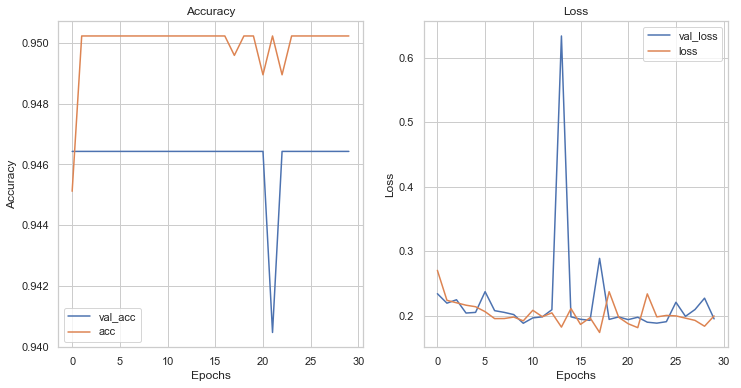

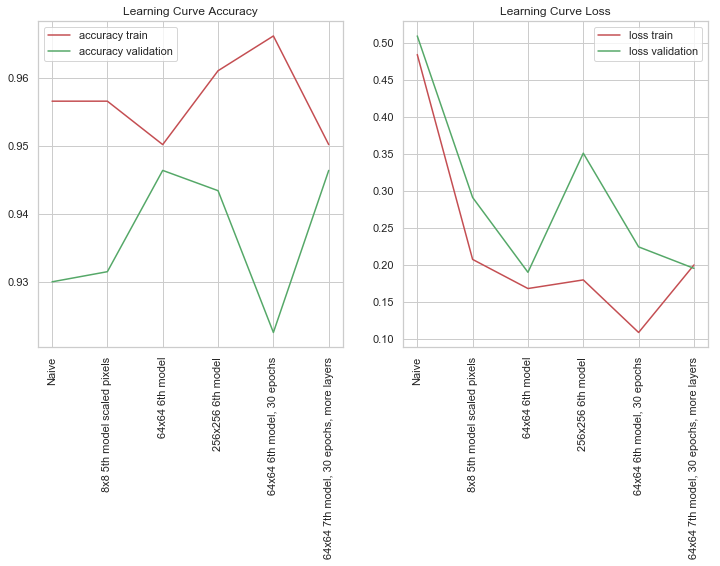

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.95660,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.95660,0.93155,0.20714,0.29107
0,64x64 6th model,0.95022,0.94643,0.16770,0.18968
0,256x256 6th model,0.96107,0.94345,0.17938,0.35100
0,"64x64 6th model, 30 epochs",0.96618,0.92262,0.10818,0.22411
0,"64x64 7th model, 30 epochs, more layers",0.95022,0.94643,0.19962,0.19504


In [97]:
df=model_results(history8, '64x64 7th model, 30 epochs, more layers', df)
df

#### Adding more layers and higher resolution images

In [98]:
model7b = models.Sequential()
model7b.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model7b.add(layers.MaxPooling2D((2, 2)))

model7b.add(layers.Conv2D(10, (4, 4), activation='relu'))
model7b.add(layers.MaxPooling2D((2, 2)))

model7b.add(layers.Conv2D(32, (3, 3), activation='relu'))
model7b.add(layers.MaxPooling2D((2, 2)))

model7b.add(layers.Flatten())
model7b.add(layers.Dense(32, activation='relu'))
model7b.add(layers.Dense(9, activation='softmax'))

model7b.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [99]:
#history8b = model7b.fit(train_images_fs,
#                    train_y,
#                    epochs=30,
#                    batch_size=10, validation_split=0.3)

In [100]:
#df=model_results(history8b, '256x256 7th model', df)
#df

#### Increase the batch size: 50

In [101]:
history9 = model7.fit(train_img64,
                    train_y,
                    epochs=30,
                    batch_size=50, validation_split=0.3)

Epoch 1/30
32/32 [==============================] - 4s 109ms/step - loss: 0.1660 - acc: 0.9502 - val_loss: 0.1944 - val_acc: 0.9464
Epoch 2/30
32/32 [==============================] - 3s 100ms/step - loss: 0.2000 - acc: 0.9502 - val_loss: 0.1944 - val_acc: 0.9464
Epoch 3/30
32/32 [==============================] - 3s 101ms/step - loss: 0.1611 - acc: 0.9515 - val_loss: 0.2466 - val_acc: 0.9301
Epoch 4/30
32/32 [==============================] - 3s 100ms/step - loss: 0.1611 - acc: 0.9496 - val_loss: 0.1993 - val_acc: 0.9449
Epoch 5/30
32/32 [==============================] - 3s 106ms/step - loss: 0.1560 - acc: 0.9515 - val_loss: 0.2025 - val_acc: 0.9464
Epoch 6/30
32/32 [==============================] - 4s 115ms/step - loss: 0.1719 - acc: 0.9521 - val_loss: 0.2086 - val_acc: 0.9464
Epoch 7/30
32/32 [==============================] - 4s 132ms/step - loss: 0.1602 - acc: 0.9483 - val_loss: 0.2147 - val_acc: 0.9449
Epoch 8/30
32/32 [==============================] - 3s 102ms/step - loss: 0.

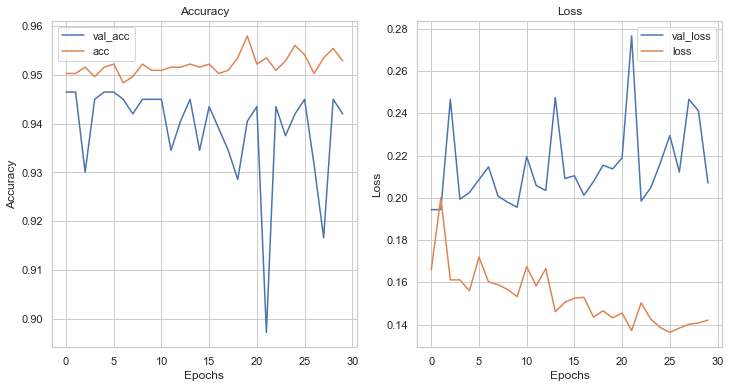

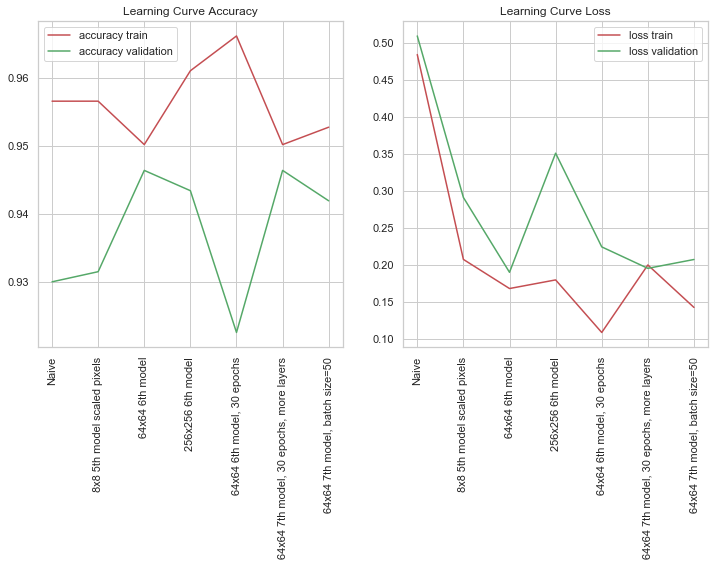

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.95660,0.93006,0.48462,0.50979
0,8x8 5th model scaled pixels,0.95660,0.93155,0.20714,0.29107
0,64x64 6th model,0.95022,0.94643,0.16770,0.18968
0,256x256 6th model,0.96107,0.94345,0.17938,0.35100
0,"64x64 6th model, 30 epochs",0.96618,0.92262,0.10818,0.22411
0,"64x64 7th model, 30 epochs, more layers",0.95022,0.94643,0.19962,0.19504
0,"64x64 7th model, batch size=50",0.95278,0.94196,0.14210,0.20703


In [102]:
df=model_results(history9, '64x64 7th model, batch size=50', df)
df

The truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
What would be more appropriate is for each change we do (in the size of the images, the number of epochs, the batch size) to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
This would be very time consuming to do by hand, so the next step we are goign to take is building a grid search for these parameteres to get a better answer in terms of which ones are the optimal charateristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
To evaluate each individual model, a 3-fold cross validation is used.

Even if we might have seen a better result with higher resolution images, we will keep the 64x64 ones for the grid search to limit the running time of our code.
Once we  find out from the GridSearch what are the best parameteres we can use those (running just one single model) with higher resolution images.

In [103]:
# Function to create model, required for KerasClassifier
def create_model():
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(10, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
    return model

In [104]:
#set X and Y
X=train_img64
Y=train_y

In [105]:
# Use scikit-learn to grid search the batch size and epochs
# create model
model = KerasClassifier(model=create_model)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
best_params=grid_result.best_params_
best_params

In [ ]:
best_batch=grid_result.best_params_['batch_size']

In [ ]:
best_epochs=grid_result.best_params_['epochs']

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [ ]:
history10 = model7.fit(train_images64,
                    train_y,
                    epochs=best_epochs,
                    batch_size=best_batch, validation_split=0.3)

In [ ]:
df=model_results(history10, 'best model 1st Gridsearch', df)
df

### Grid Search Optimization Algorithm:

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms. Here is a lists of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible combinations.

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
<br>relu
<br>swish
<br>softmax
<br>leaky relu
<br>sigmoid

<br>for optimizers:
<br>adam, sgd, 
<br>with optimizer I can also tweak the learning rate

<br>for loss functions:
categorical_crossentropy, 


We already have the function to create the model, and the X and Y we set before are teh same. We just need to change the grid for the search of the parameters.

In [ ]:
# create model
model = KerasClassifier(model=create_model, 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
best_params=grid_result.best_params_
best_params

In [ ]:
best_opti=grid_result.best_params_['optimizer']

Creating a new model with the selected optimizer algorithm:

In [ ]:
 # create model
model8 = models.Sequential()
model8.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64,64, 3)))
model8.add(layers.MaxPooling2D((2, 2)))
    
model8.add(layers.Conv2D(10, (4, 4), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))

model8.add(layers.Conv2D(32, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))

model8.add(layers.Flatten())
model8.add(layers.Dense(32, activation='relu'))
model8.add(layers.Dense(9, activation='softmax'))

# Compile model
model8.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])

In [ ]:
history11 = model8.fit(train_img64,
                    train_y,
                    epochs=best_epochs,
                    batch_size=best_batch, validation_split=0.3)

In [ ]:
df=model_results(history11, 'best model Gridsearch optimization', df)
df

### Grid Search Learning Rate and Momentum

In [ ]:
# Need to add here

In [ ]:
# another grid search

In [ ]:
# for learning rate and momentum

We could also do a grid search to choose the best activation function, but it doesn't make much sense in our multiclass case because the most popular one is softmax for this case, there aren't really that many options. But we will do this type of grid search later when we will reduce our problem to a binary classification problem, and there will be more options of activation fucntions to use at that point.

What we can still tune though is the number of neurons in the hidden layers.
We will do this with another grid search.

### Grid Search number of neurons:

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

In [ ]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

In [ ]:
# create model
model = KerasClassifier(model=create_model, epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
neurons = [5, 10, 20, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
neurons=grid_result.best_params_['model__neurons']

In [ ]:
model9 = models.Sequential()
model9.add(layers.Conv2D(neurons, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model9.add(layers.MaxPooling2D((2, 2)))
    
model9.add(layers.Conv2D(neurons, (4, 4), activation='relu'))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(neurons, (3, 3), activation='relu'))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Flatten())
model9.add(layers.Dense(32, activation='relu'))
model9.add(layers.Dense(9, activation='softmax'))

# Compile model
model9.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])

In [ ]:
history12 = model9.fit(train_img64,
                    train_y,
                    epochs=best_epochs,
                    batch_size=best_batch, validation_split=0.3)

In [ ]:
df=model_results(history11, 'best model Gridsearch neurons', df)
df

## Tuning

### Regularization

In [ ]:
from tensorflow.keras import regularizers

model9 = models.Sequential()
model9.add(layers.Conv2D(neurons, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model9.add(layers.MaxPooling2D((2, 2)))
    
model9.add(layers.Conv2D(neurons, (4, 4), activation='relu',
                         kernel_regularizer=regularizers.L2(l2=0.05)))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(neurons, (3, 3), activation='relu', 
                        kernel_regularizer=regularizers.L2(l2=0.05)))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Flatten())
model9.add(layers.Dense(32, activation='relu', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model9.add(layers.Dense(9, activation='softmax'))

# Compile model
model9.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])

In [ ]:
history13 = model9.fit(train_img64,
                    train_y,
                    epochs=best_epochs,
                    batch_size=best_batch, validation_split=0.3)

In [ ]:
df=model_results(history11, 'after regularization', df)
df

>Look into L1 and see if it makes sense to do L1 regularization too.
>Play also around a bit and find the best parameters for L1 and L2.

### Dropout Regularization

>Check out grid search blogpost

### Early Stopping

#### Best model

#### Testing on the test

## Changing to two classes cancerous and bening

In [ ]:
# Work on the data

In [ ]:
# If there is an imbalance re balance the classes with augmentation

In [ ]:
# Create function to extract recall

In [ ]:
y_hat_train=model.predict(train_img)
y_hat_test=model.predict(test_img)

Clearly here I have to round to get the actual prediction for the class.

In [ ]:
pr_train=precision_score(train_labels, train_labels, average=None)
#rec_train=recall_score(train_labels, y_hat_train)
#acc_train=accuracy_score(train_labels, y_hat_train)
#f1_train=f1_score(train_labels, y_hat_train)

#pr_test=precision_score(test_labels, y_hat_test)
#rec_test=recall_score(test_labels, y_hat_test)
#acc_test=accuracy_score(test_labels, y_hat_test)
#f1_test=f1_score(test_labels, y_hat_test)
pr_train
#print("Train: \nprecision", pr_train,"\nrecall:", rec_train, '\naccuracy:', acc_train, '\nf1 score:', f1_train,'\n')
#print("Test: \nprecision", pr_test,"\nrecall:", rec_test, '\naccuracy:', acc_test, '\nf1 score:', f1_test)

In [ ]:
# Create function to compare the models (similar to previous one but comparing recall)

### Re tuning of the parameters
With this time binary classification problem

In [ ]:
# Grid Searches

In [ ]:
# Tuning with normalization and regularization

In [ ]:
# Best model

In [ ]:
# Testing on the test set

## LIME